In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем библиотеку squarify для создания диаграммы Treemap
import squarify
# Импортируем класс WordCloud для создания облака слов
from wordcloud import WordCloud
# Импортируем библиотеку nltk для работы с естественным языком
import nltk
# Загружаем лексикон VADER, необходимый для анализа тональности текста
nltk.download('vader_lexicon')
# Импортируем SentimentIntensityAnalyzer для анализа тональности текста с помощью VADER
from nltk.sentiment import SentimentIntensityAnalyzer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Файлы для соревнования
* hotels_train.csv - набор данных для обучения
* hotels_test.csv - набор данных для оценки качества
* submission.csv - файл сабмишна в нужном формате

### Признаки
* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

df_train.info()

In [5]:
# Посмотрим на данные
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [6]:
# Изучим тип данных и их количество
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
# Посмотрим на данные
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [8]:
# Посмотрим на данные
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [9]:
# Изучим тип данных и их количество
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# Уберем дубликаты в тестовым данных
df_train.duplicated().sum()
df_train.drop_duplicates(inplace=True)
df_train.shape[0]

# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
# Посмотрим на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [12]:
# Посчитаем NaN
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

<AxesSubplot:>

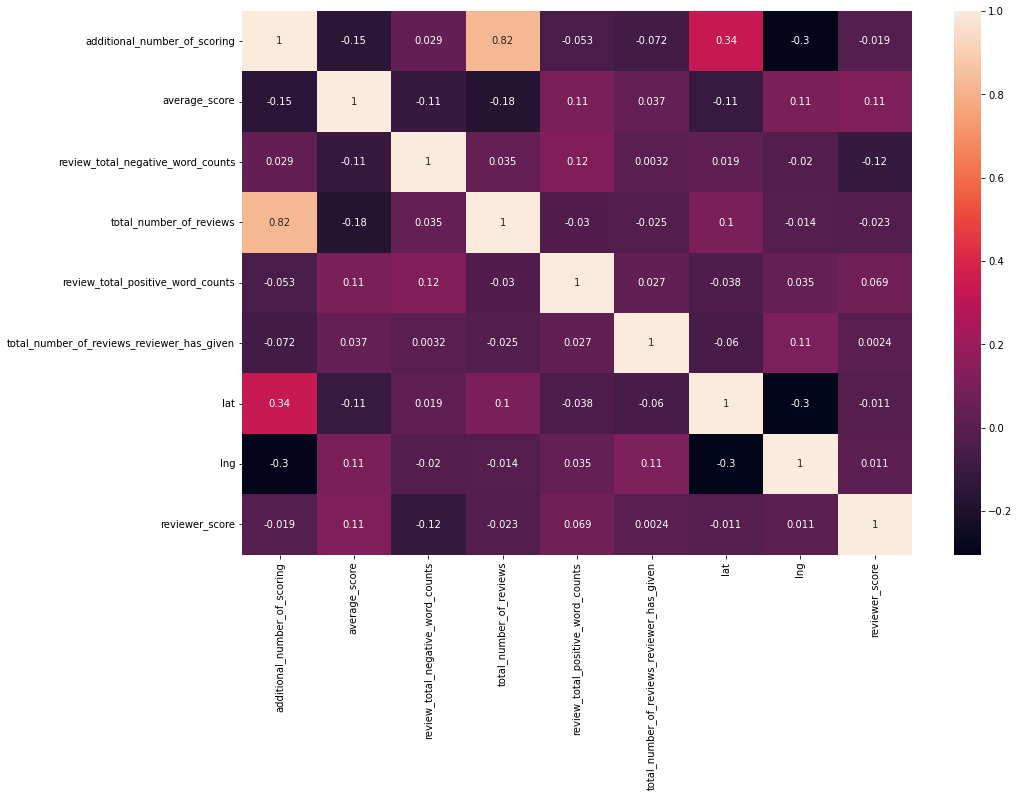

In [13]:
# Построим матрицу корреляции Пирсона
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

# Очистка данных

In [14]:
# Отделим число от слова "день" и переведем в int
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])
data['days_since_review'] = data['days_since_review'].astype('int64')

In [15]:
# Приведем к правильному формату
data['review_date'] = pd.to_datetime(data['review_date'])

# Исследование данных

In [16]:
# Отфильтруем только тестовые данные для анализа влияния средней оценки
filtered_data = data[data['sample'] == 1]

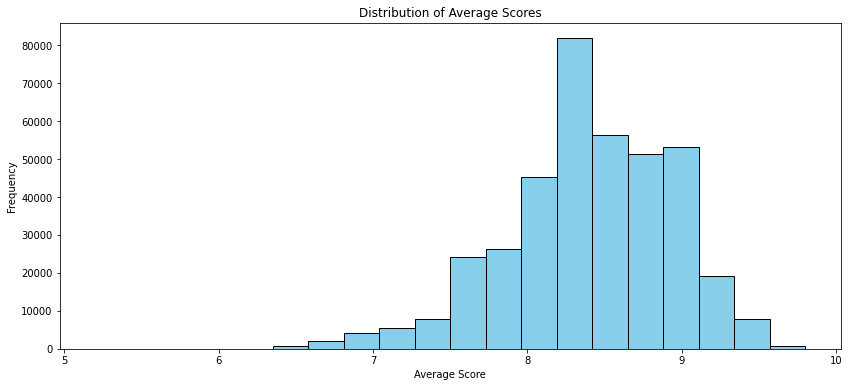

In [17]:
# Посмотрим на распределение средней оценки отеля данных для обучения
plt.figure(figsize=(14, 6))
plt.hist(filtered_data['average_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.show()

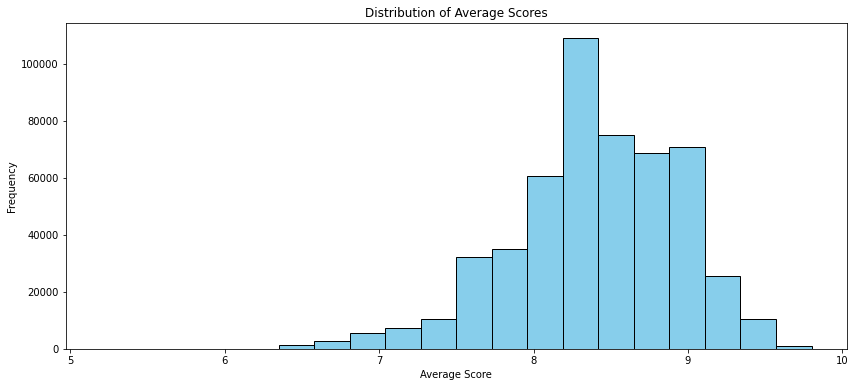

In [18]:
# Посмотрим на распределение средней оценки отеля всех данных
plt.figure(figsize=(14, 6))
plt.hist(data['average_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.show()

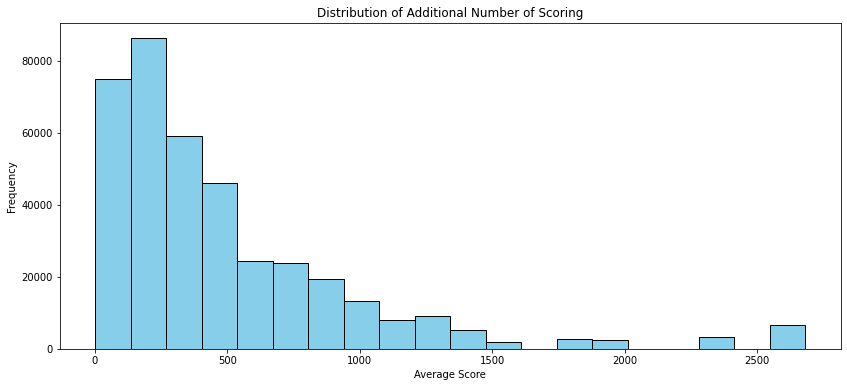

In [19]:
# Посмотрим на распределение дополнительной оценки ревьюера данных для обучения
plt.figure(figsize=(14, 6))
plt.hist(filtered_data['additional_number_of_scoring'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Additional Number of Scoring')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.show()

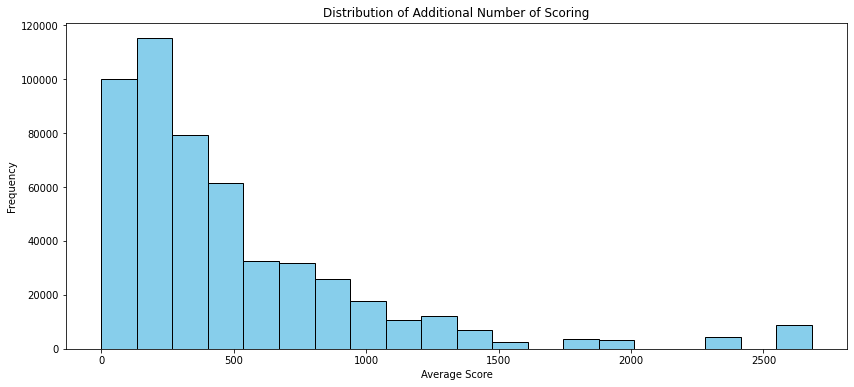

In [20]:
# Посмотрим на распределение дополнительной оценки ревьюера для всех данных
plt.figure(figsize=(14, 6))
plt.hist(data['additional_number_of_scoring'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Additional Number of Scoring')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.show()

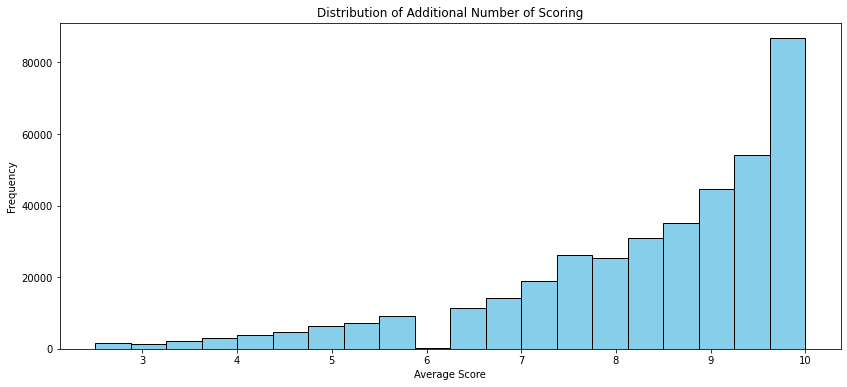

In [21]:
# Посмотрим на распределение оценки ревьюера данных для обучения
plt.figure(figsize=(14, 6))
plt.hist(filtered_data['reviewer_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Additional Number of Scoring')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.show()

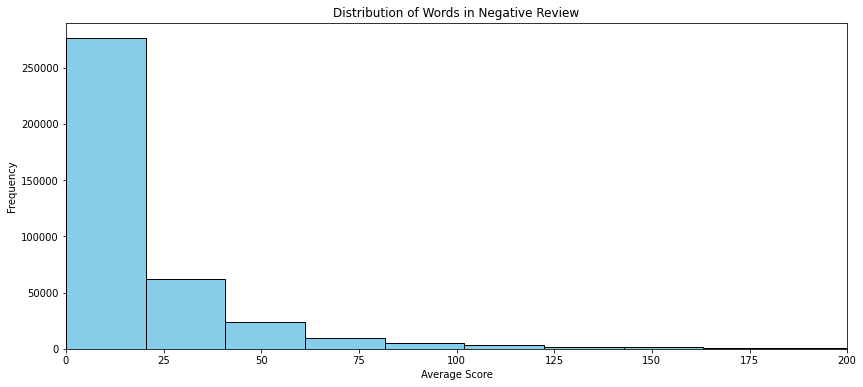

In [22]:
# Посмотрим на количество слов в негативном отзыве данных для обучения
plt.figure(figsize=(14, 6))
plt.hist(filtered_data['review_total_negative_word_counts'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Words in Negative Review')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.xlim(0,200)
plt.show()

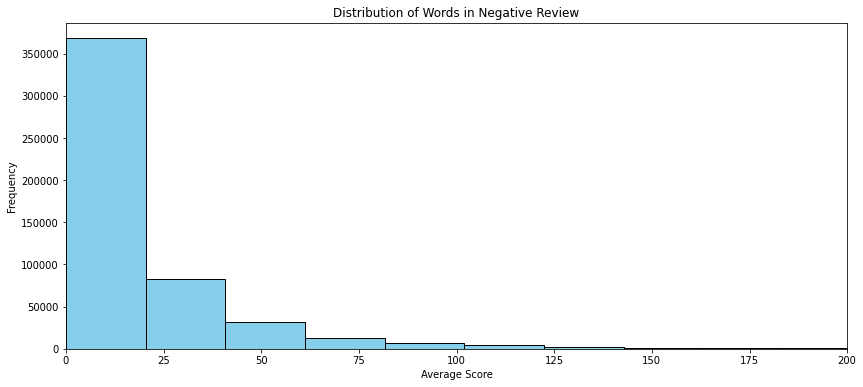

In [23]:
# Посмотрим на количество слов в негативном отзыве для всех данных
plt.figure(figsize=(14, 6))
plt.hist(data['review_total_negative_word_counts'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Words in Negative Review')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.xlim(0,200)
plt.show()

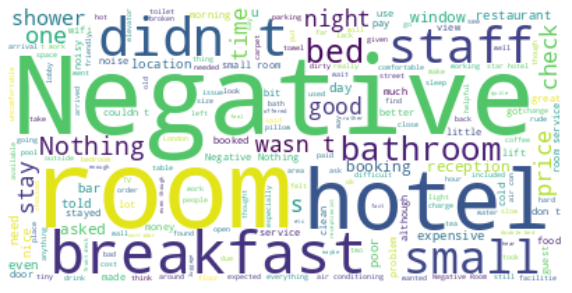

In [24]:
# Построим облако слов в негативном отзыве данных для обучения
all_negative_reviews = ' '.join(filtered_data['negative_review'])

wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue').generate(all_negative_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

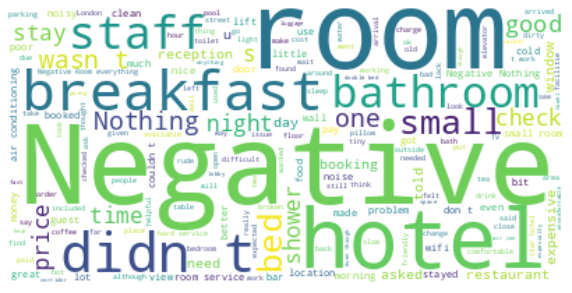

In [25]:
# Построим облако слов в негативном отзыве для всех данных
all_negative_reviews = ' '.join(data['negative_review'])

wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue').generate(all_negative_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

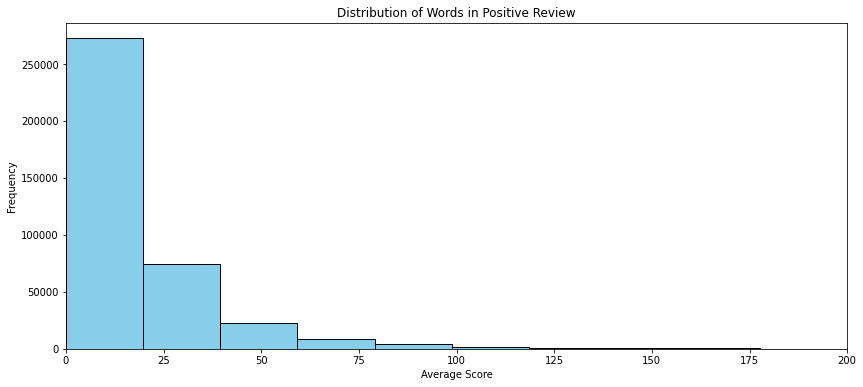

In [26]:
# Посмотрим на количество слов в позитивном отзыве данных для обучения
plt.figure(figsize=(14, 6))
plt.hist(filtered_data['review_total_positive_word_counts'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Words in Positive Review')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.xlim(0, 200)
plt.show()

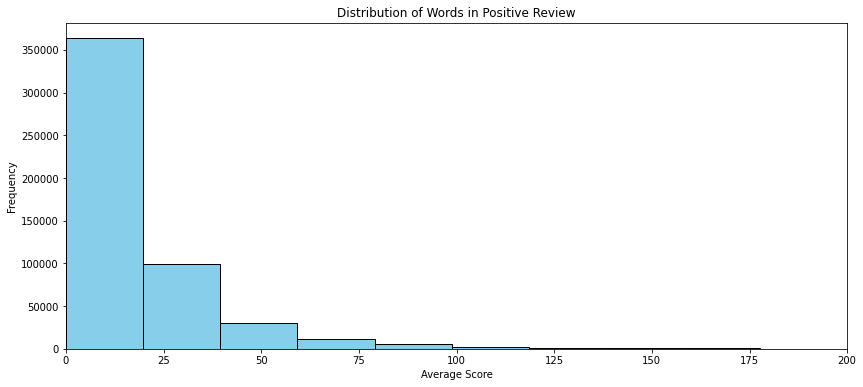

In [27]:
# Посмотрим на количество слов в позитивном отзыве для всех данных
plt.figure(figsize=(14, 6))
plt.hist(data['review_total_positive_word_counts'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Words in Positive Review')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.xlim(0, 200)
plt.show()

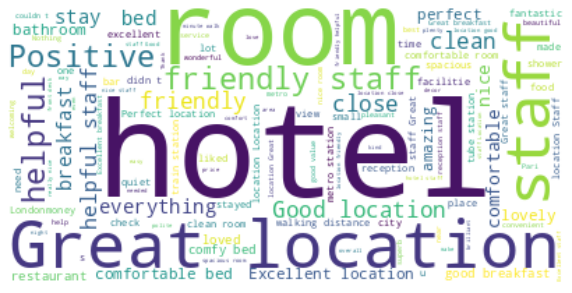

In [28]:
# Построим облако слов в позитивном отзыве данных для обучения
all_positive_reviews = ' '.join(filtered_data['positive_review'])

wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue').generate(all_positive_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

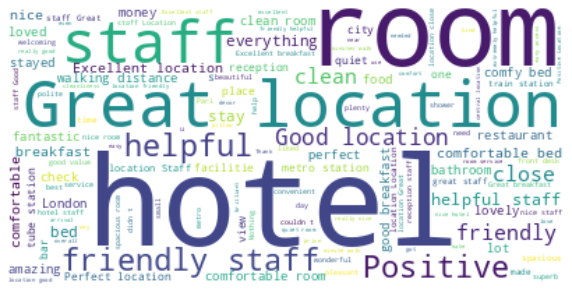

In [29]:
# Построим облако слов в позитивном отзыве для всех данных
all_positive_reviews = ' '.join(data['positive_review'])

wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue').generate(all_positive_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [30]:
# Посчитаем количество вхождений для национальности ревьюера
nationality_counts = filtered_data['reviewer_nationality'].value_counts()
# Отберем топ 10
top_10_nationalities = nationality_counts[:10]
# Посчитаем количество в топ 10
other_count = nationality_counts[10:].sum()
# Запишем других как other
top_10_with_other = top_10_nationalities.append(pd.Series([other_count], index=['Other']))

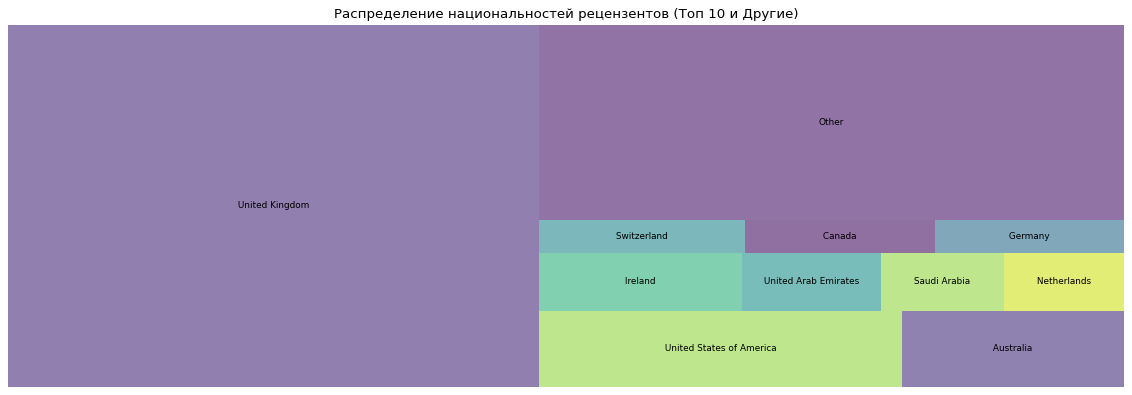

In [31]:
# Построим tree plot для национальностей в топе
plt.figure(figsize=(18,6), dpi=80)
squarify.plot(sizes=top_10_with_other.values, 
              label=top_10_with_other.index, 
              alpha=0.6, text_kwargs={'fontsize':8})

plt.title('Распределение национальностей рецензентов (Топ 10 и Другие)')
plt.axis('off')
plt.show()

In [32]:
# Группируем данные по национальности рецензента и вычисляем средний балл отзывов
nationality_scores = filtered_data.groupby('reviewer_nationality')['reviewer_score'].mean()
# Находим 10 наиболее часто встречающихся национальностей в отзывах
top_nationalities = filtered_data['reviewer_nationality'].value_counts().nlargest(10).index
# Извлекаем средние баллы для этих топ-10 национальностей
top_nationality_scores = nationality_scores.loc[top_nationalities]
# Извлекаем средние баллы для остальных национальностей (не входящих в топ-10)
other_nationality_scores = nationality_scores.loc[~nationality_scores.index.isin(top_nationalities)]
# Вычисляем средний балл для "остальных" национальностей
other_avg_score = other_nationality_scores.mean()
# Добавляем полученный средний балл для "остальных" национальностей в итоговый DataFrame
top_nationality_scores = top_nationality_scores.append(pd.Series(other_avg_score, index=['Other']))
# Сортируем результаты по убыванию среднего балла
top_nationality_scores = top_nationality_scores.sort_values(ascending=False)


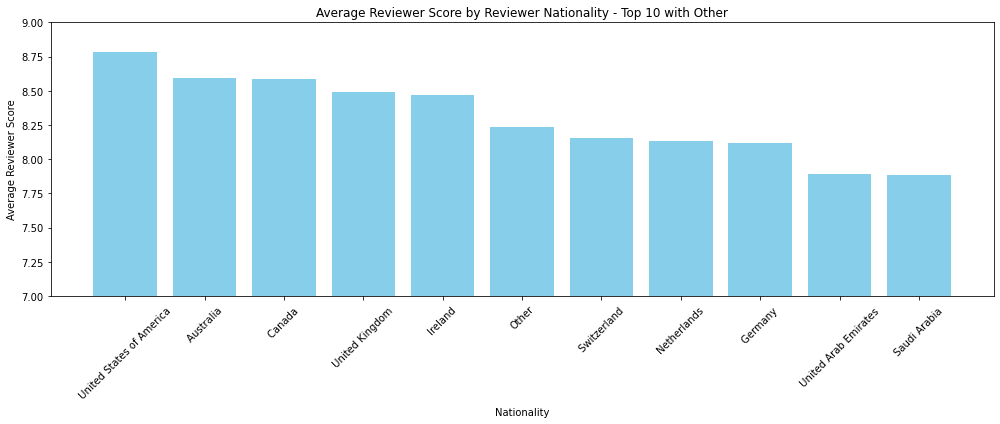

In [33]:
# Построим столбчатую диаграмму, которая визуализирует средний балл отзывов по национальности рецензента
plt.figure(figsize=(14, 6))
plt.bar(top_nationality_scores.index, top_nationality_scores.values, color='skyblue')

plt.xlabel('Nationality')
plt.ylabel('Average Reviewer Score')
plt.title('Average Reviewer Score by Reviewer Nationality - Top 10 with Other')
plt.xticks(rotation=45)  
plt.ylim(7, 9)

plt.tight_layout()
plt.show()

In [34]:
# Посмотрим на продолжительность между датой проверки и датой очистки данных для обучения
filtered_data['days_since_review'].describe()

count    386496.000000
mean        354.339339
std         208.958145
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

In [35]:
# Посмотрим на продолжительность между датой проверки и датой очистки для всех данных
data['days_since_review'].describe()

count    515431.000000
mean        354.405492
std         208.915335
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

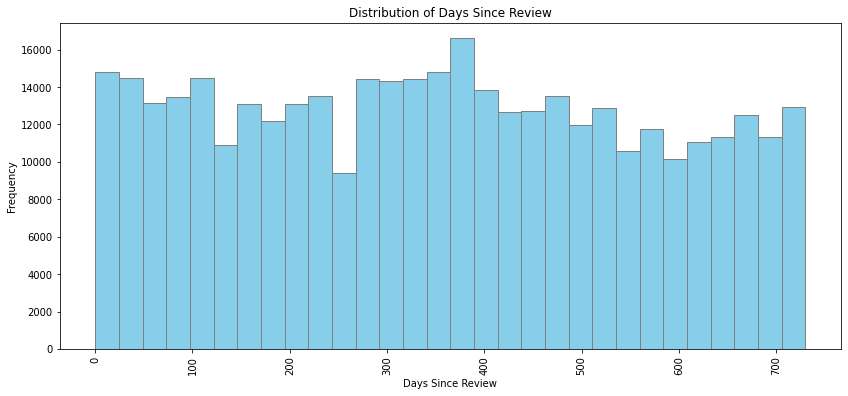

In [36]:
# Построим распередление продолжительности между датой проверки и датой очистки данных для обучения
plt.figure(figsize=(14, 6))
plt.hist(filtered_data['days_since_review'], bins=30, color='skyblue', edgecolor='grey')
plt.title('Distribution of Days Since Review')
plt.xlabel('Days Since Review')
plt.ylabel('Frequency')
plt.xticks(rotation=90) 
plt.show()

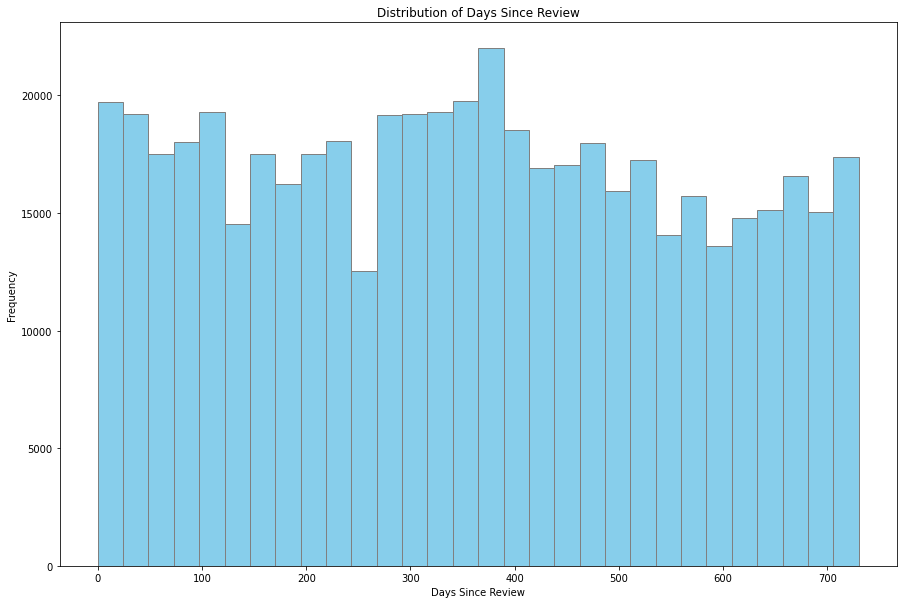

In [37]:
# Построим распередление продолжительности между датой проверки и датой очистки для всех данных
plt.hist(data['days_since_review'], bins=30, color='skyblue', edgecolor='grey')
plt.title('Distribution of Days Since Review')
plt.xlabel('Days Since Review')
plt.ylabel('Frequency')
plt.show()

In [38]:
# Опишем сколько ревью вообще было дано
data['total_number_of_reviews_reviewer_has_given'].describe()

count    515431.000000
mean          7.165215
std          11.038742
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

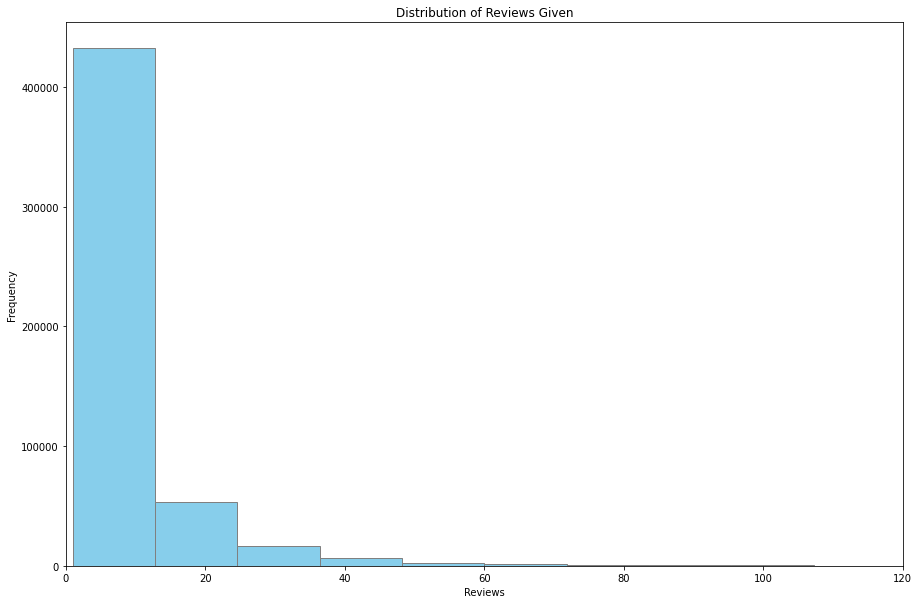

In [39]:
plt.hist(data['total_number_of_reviews_reviewer_has_given'], bins=30, color='skyblue', edgecolor='grey')
plt.title('Distribution of Reviews Given')
plt.xlabel('Reviews')
plt.ylabel('Frequency')
plt.xlim(0, 120)
plt.show()

# Генерация признаков и исследование этих данных

In [40]:
# Создаем экземпляр анализатора тональности SentimentIntensityAnalyzer
# Sentiment Analysis is the process of 'computationally' determining whether a piece of writing is positive, negative or neutral
sent_analyzer = SentimentIntensityAnalyzer()

# Определяем функцию для вычисления комплексного показателя тональности отзыва
def find_score_review(review):
    # Получаем оценки тональности для переданного отзыва
    result = sent_analyzer.polarity_scores(review) 
    # Возвращаем комплексный показатель тональности, который объединяет все оценки
    return result['compound']

# Применяем функцию к каждому отрицательному отзыву в датафрейме и сохраняем результаты в новом столбце 'score_negative'
data['score_negative'] = data['negative_review'].apply(find_score_review)
# Применяем функцию к каждому положительному отзыву в датафрейме и сохраняем результаты в новом столбце 'score_positive'
data['score_positive'] = data['positive_review'].apply(find_score_review)

In [41]:
# Определение функции get_season, которая принимает объект даты
def get_season(date):
    if date.month in [3, 4, 5]:
        return 'spring'
    elif date.month in [6, 7, 8]:
        return 'summer'
    elif date.month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'
    
# Создадим колонку с сезоном
data['season'] = data['review_date'].apply(get_season)

In [42]:
# Создадим новую колонку с месяцем
data['month'] = data['review_date'].dt.month

In [43]:
# Создадим новую колонку с днем недели
data['weekday'] = data['review_date'].dt.weekday

In [44]:
data['tags'].head()

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
Name: tags, dtype: object

In [45]:
# Определяем функцию для разделения тегов
def tag_separation(tags):
    # Удаляем первые два и последние два символа в строке tags
    tags = tags[2:-2]
    # Удаляем пробелы в начале и конце строки (если они есть), затем разделяем строку на список строк по разделителю " \', \' ".
    result = tags.strip().split(' \', \' ')
    return result

# Применяем функцию к тегам и записываем результат в новой колонке
data['tags_new'] = data['tags'].apply(tag_separation)

In [46]:
# Изучим данные
data['tags_new'][0]

['Leisure trip', 'Couple', 'Double Room', 'Stayed 2 nights']

In [47]:
# Изучим данные
data['tags_new'][9]

['Couple',
 'Standard Triple Room',
 'Stayed 2 nights',
 'Submitted from a mobile device']

In [48]:
# Определение функции trip, которая принимает строку в качестве входного параметра
def trip(string):
    for tag in string:
        # Проверка, содержит ли тег подстроку 'trip'
        if 'trip' in tag:
            return tag
    return 'Unkown trip'

# Применяем функцию к тегам и записываем результат в новой колонке
data['trip_purpose'] = data['tags_new'].apply(trip)

In [49]:
# Определение функции status, которая принимает строку в качестве входного параметра
def status(string):
    for tag in string:
        # Проверяем, содержит ли тег слово 'trip'
        if 'trip' in tag:
             # Если да, возвращаем второй тег в списке, предполагая, что он относится к статусу поездки
            return string[1]
        else:
            # Если тег 'trip' не найден в первом теге, возвращаем первый тег в списке
            return string[0]

# Применяем функцию к тегам и записываем результат в новой колонке
data['status'] = data['tags_new'].apply(status)

In [50]:
# Определение функции trip, которая принимает строку в качестве входного параметра
def room(string):
    for tag in string:
        if len(string)>2:
            # Проверка, содержит ли тег подстроку 'trip'
            if 'trip' in tag:
                return string[2]
            else:
                return string[1]
        # Если ни один тег не содержит подстроку 'trip', возвращаем 'Unkown trip'
        if len(string)<=2:
            return None

# Применяем функцию к тегам и записываем результат в новой колонке      
data['room'] = data['tags_new'].apply(room)

In [51]:
# Определение функции night, которая принимает строку в качестве входного параметра
def night(string):
    for tag in string:
        # Проверка, содержит ли тег подстроку 'stayed'
        if 'Stayed' in tag:
            return tag.split()[1]
    return None

# Применяем функцию к тегам и записываем результат в новой колонке
data['days_of_stay'] = data['tags_new'].apply(night)

In [52]:
# Определение функции app, которая принимает строку в качестве входного параметра
def app(string):
    for tag in string:
        # Проверяем, содержит ли тег слово 'submitted'
        if 'Submitted' in tag:
            return 1
    return 0

# Применяем функцию к тегам и записываем результат в новой колонке
data['app'] = data['tags_new'].apply(app)

In [53]:
# Изучим данные
data['hotel_address'].head(10)

0                   Via Senigallia 6 20161 Milan Italy
1    Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2          Mallorca 251 Eixample 08008 Barcelona Spain
3    Piazza Della Repubblica 17 Central Station 201...
4    Singel 303 309 Amsterdam City Center 1012 WJ A...
5    Coram Street Camden London WC1N 1HT United Kin...
6    Empire Way Wembley Brent London HA9 8DS United...
7    1 Shortlands Hammersmith and Fulham London W6 ...
8          35 Rue Caumartin 9th arr 75009 Paris France
9    49 Gloucester Place Marble Arch Westminster Bo...
Name: hotel_address, dtype: object

In [54]:
# Найдем страну, которая последняя в списке(отличие - UK)
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

In [55]:
# Найдем город, который предпоследний в списке (отличие - UK)
data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.split()[-1] == 'Kingdom' else x.split()[-2])

In [56]:
# Отфильтруем данные только тестовой выборки
filtered_data = data[data['sample'] == 1]

In [57]:
# Найдем средний балл для каждого сезона
average_score_by_season = filtered_data.groupby('season')['reviewer_score'].mean()

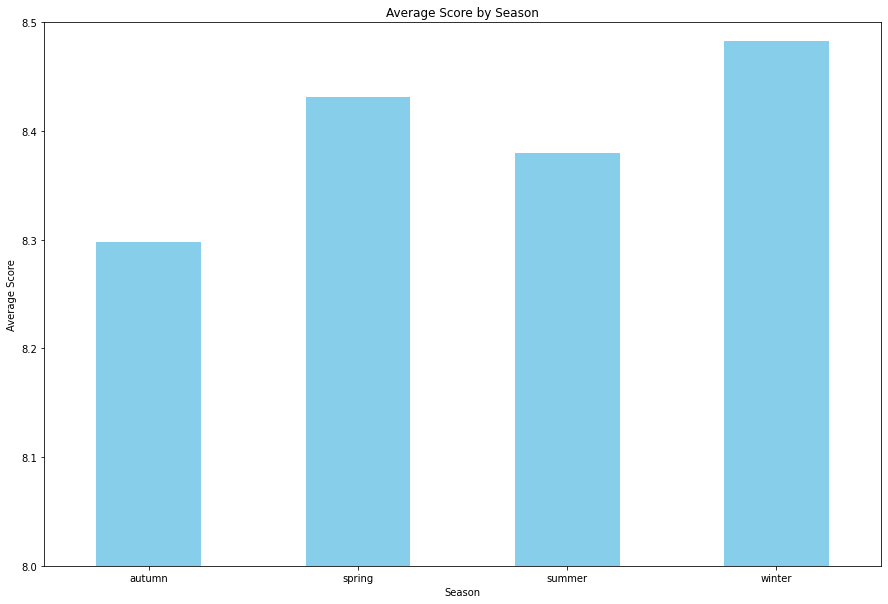

In [58]:
# Построим столбчатую диаграмму, где отразим средний балл по сезону
average_score_by_season.plot(kind='bar', color='skyblue')
plt.title('Average Score by Season')
plt.xlabel('Season')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.ylim(8, 8.5)
plt.show()

In [59]:
# Найдем средний балл для каждого месяца
average_score_by_month = filtered_data.groupby('month')['reviewer_score'].mean()

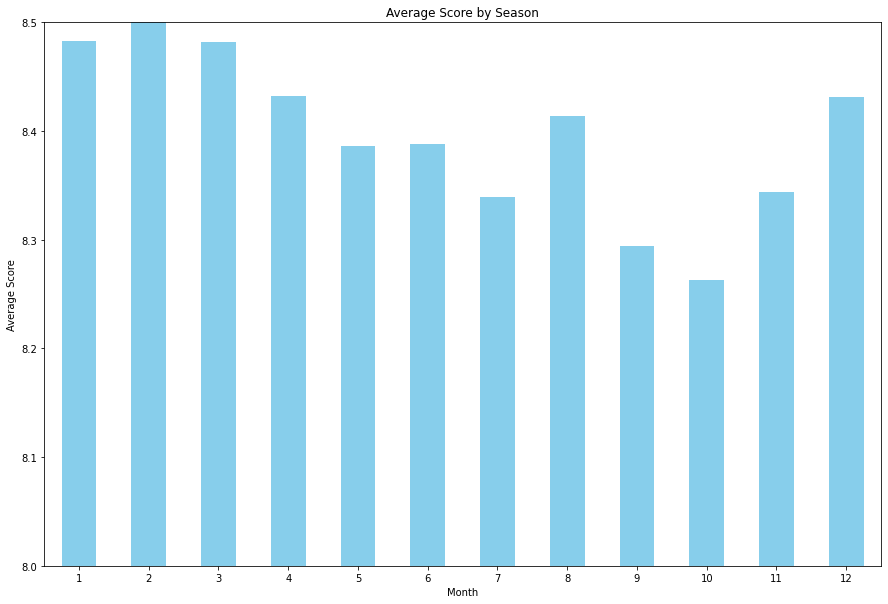

In [60]:
# Построим столбчатую диаграмму, где отразим средний балл по месяцу
average_score_by_month.plot(kind='bar', color='skyblue')
plt.title('Average Score by Season')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.ylim(8, 8.5)
plt.show()

In [61]:
# Найдем средний балл для каждого дня недели
average_score_by_weekday = filtered_data.groupby('weekday')['reviewer_score'].mean()

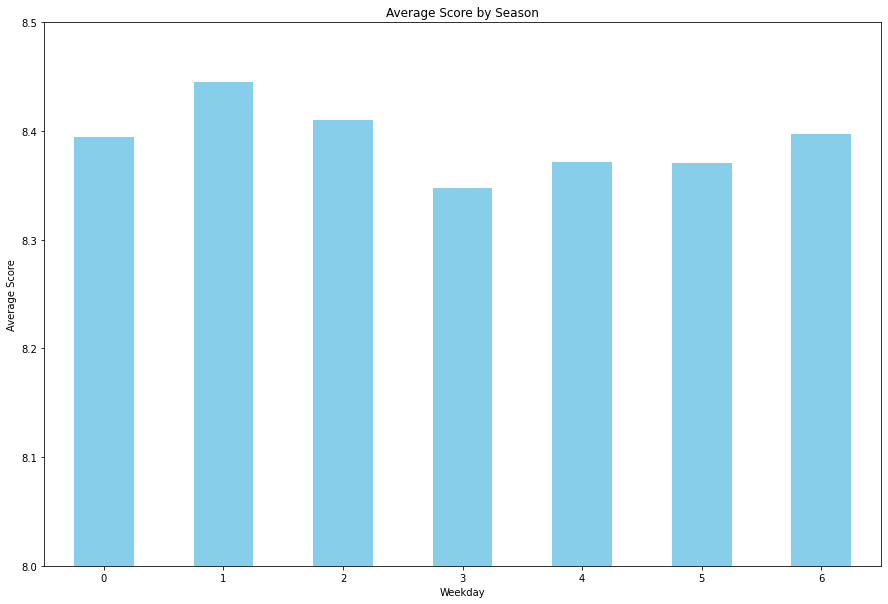

In [62]:
# Построим столбчатую диаграмму, где отразим средний балл по дню недели
average_score_by_weekday.plot(kind='bar', color='skyblue')
plt.title('Average Score by Season')
plt.xlabel('Weekday')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.ylim(8, 8.5)
plt.show()

In [63]:
# Посчитаем значения для каждого типа путешествий
trip_purpose_counts = data['trip_purpose'].value_counts()

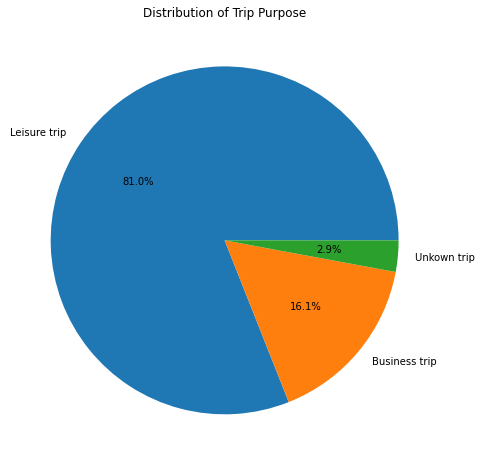

In [64]:
# Построим piechart для типа путешествий
plt.figure(figsize=(8, 8))
plt.pie(trip_purpose_counts, labels=trip_purpose_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Trip Purpose')
plt.show()

In [65]:
# Посчитаем средний скор для каждого вида путешествий
average_score_by_trip_purpose = filtered_data.groupby('trip_purpose')['reviewer_score'].mean()

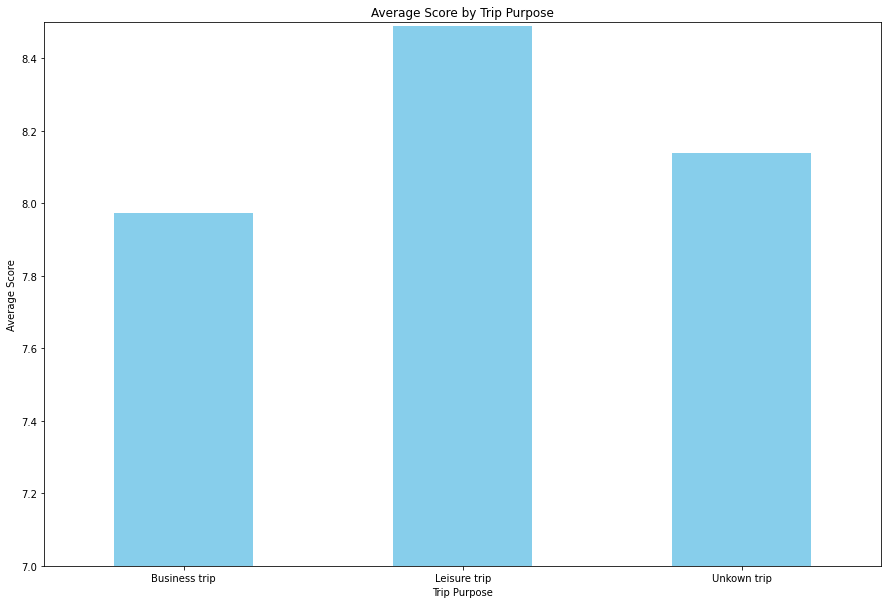

In [66]:
# Построим столбчатую диаграмму, где отразим средний скор
average_score_by_trip_purpose.plot(kind='bar', color='skyblue')
plt.title('Average Score by Trip Purpose')
plt.xlabel('Trip Purpose')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.ylim(7, 8.5)
plt.show()

In [67]:
# Посчитаем количество проведенных дней
stay_counts = data['days_of_stay'].value_counts()

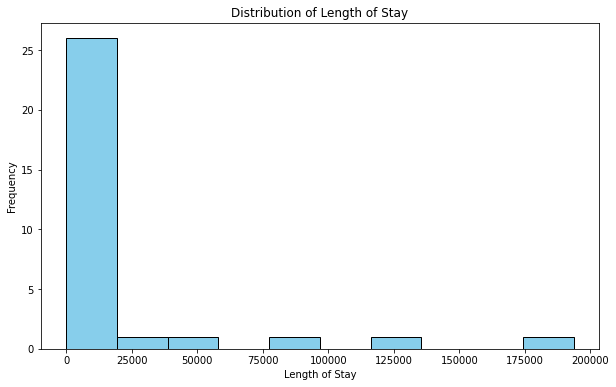

In [68]:
# Построим распределение
plt.figure(figsize=(10, 6))
plt.hist(stay_counts, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.show()

In [69]:
# Посчитаем средний скор для количества проведенных дней
average_score_by_days_of_stay = filtered_data.groupby('days_of_stay')['reviewer_score'].mean()

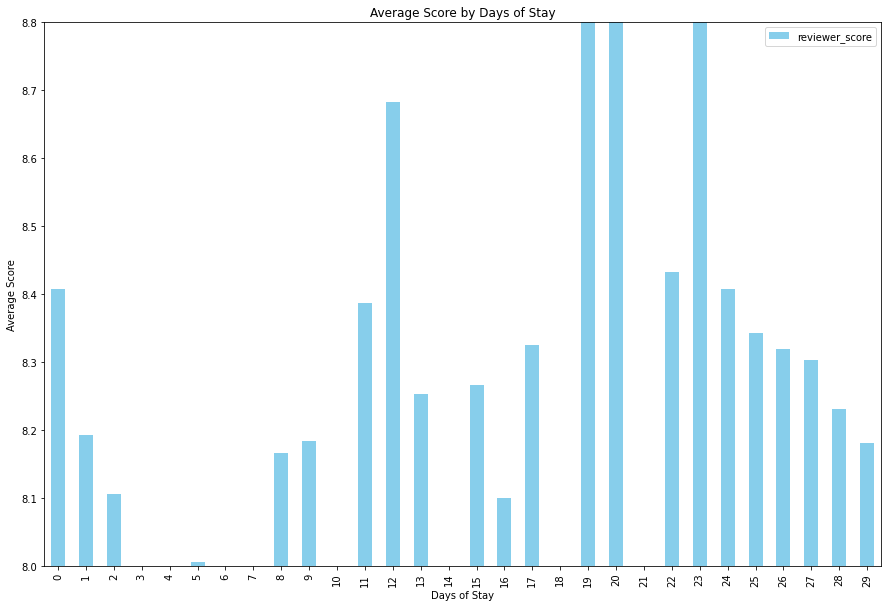

In [70]:
# Построим столбчатую диаграмму, где отразим средний скор
average_score_by_days_of_stay.reset_index().plot(kind='bar', color='skyblue')
plt.title('Average Score by Days of Stay')
plt.xlabel('Days of Stay')
plt.ylabel('Average Score')
plt.xticks(rotation=90)
plt.ylim(8, 8.8)
plt.show()

In [71]:
# Опишем какие комнаты есть
data['room'].describe()

count          515340
unique           2393
top       Double Room
freq            35124
Name: room, dtype: object

In [72]:
# Посчитаем количество статусов у путешественников
status_counts = data['status'].value_counts()

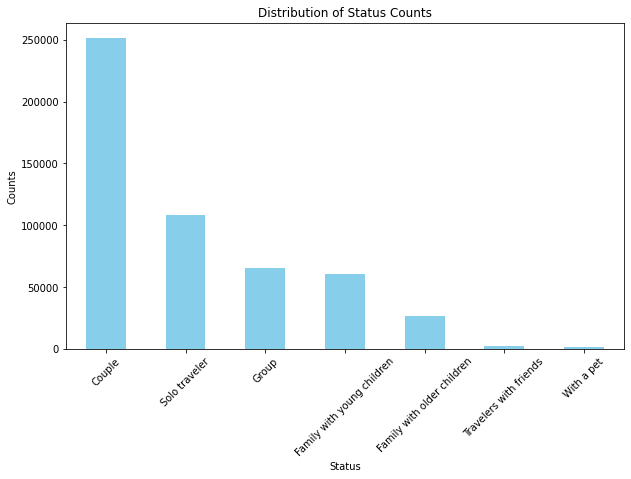

In [73]:
# Построим столбчатую диаграмму
plt.figure(figsize=(10, 6))
status_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Status Counts')
plt.xlabel('Status')
plt.ylabel('Counts')
plt.xticks(rotation=45) 
plt.show()

In [74]:
# Посчитаем средний скор для каждого статуса
average_score_by_status = filtered_data.groupby('status')['reviewer_score'].mean()

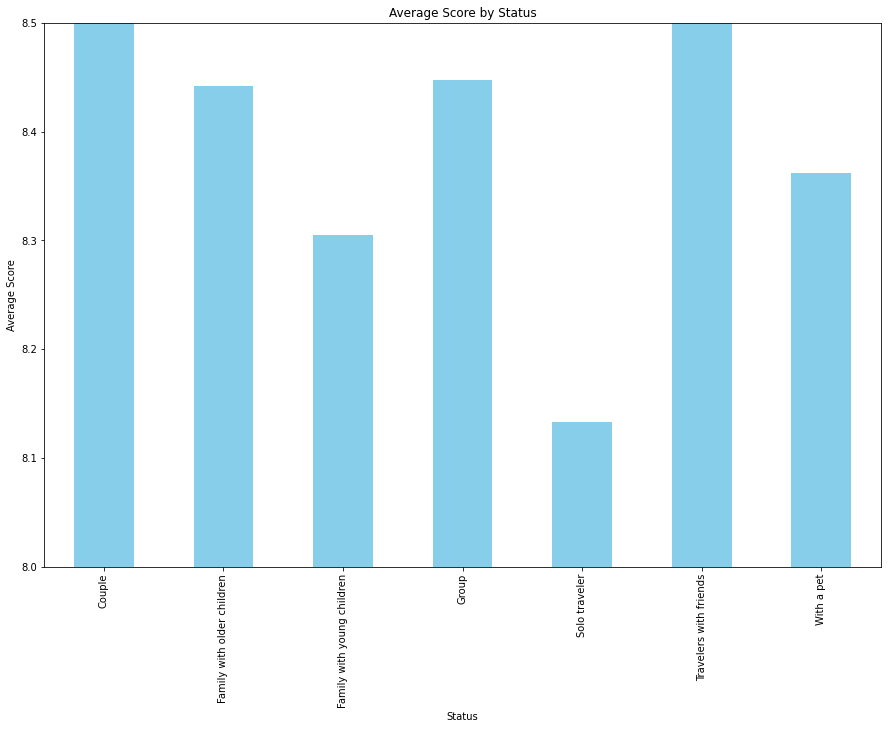

In [75]:
# Построим столбчатую диаграмму, где отразим средний скор
average_score_by_status.plot(kind='bar', color='skyblue')
plt.title('Average Score by Status')
plt.xlabel('Status')
plt.ylabel('Average Score')
plt.xticks(rotation=90)
plt.ylim(8, 8.5)
plt.show()

In [76]:
# Переведем в лейблы
data['app_label'] = data['app'].map({1: 'app', 0: 'not via app'})
# Посчитаем значения для каждого лейбла
app_counts = data['app_label'].value_counts()

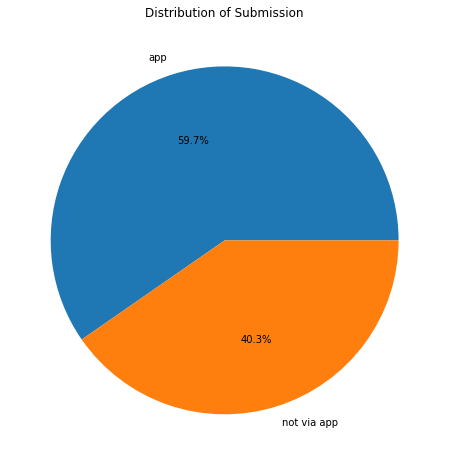

In [77]:
# Построим piechart
plt.figure(figsize=(8, 8))
plt.pie(app_counts, labels=app_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Submission')
plt.show()

In [78]:
# Посчитаем значения для города и страны
city_counts = filtered_data['hotel_city'].value_counts()
country_counts = filtered_data['hotel_country'].value_counts()

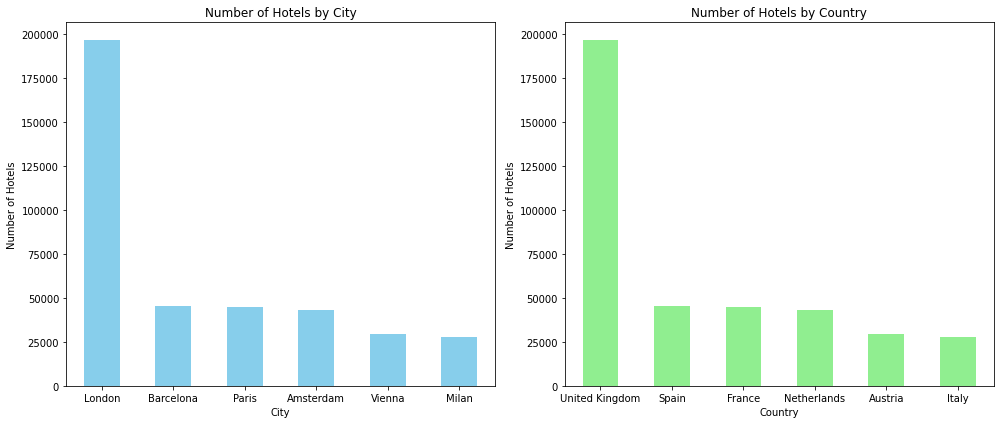

In [79]:
# Построим столбчатые диаграммы для страны и для города
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

city_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_xlabel('City')
axes[0].set_ylabel('Number of Hotels')
axes[0].set_title('Number of Hotels by City')
axes[0].tick_params(axis='x', rotation=0)

country_counts.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Number of Hotels')
axes[1].set_title('Number of Hotels by Country')
axes[1].tick_params(axis='x', rotation=0)  

plt.tight_layout()
plt.show()

In [80]:
# Посчитаем средний скор для каждой страны и каждого города
avg_score_by_country = filtered_data.groupby('hotel_country')['reviewer_score'].mean().loc[["United Kingdom", "Spain", "France", 'Netherlands', 'Austria', 'Italy']].reset_index()
avg_score_by_city = filtered_data.groupby('hotel_city')['reviewer_score'].mean().loc[["London", "Barcelona", "Paris", 'Amsterdam', 'Vienna', 'Milan']].reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


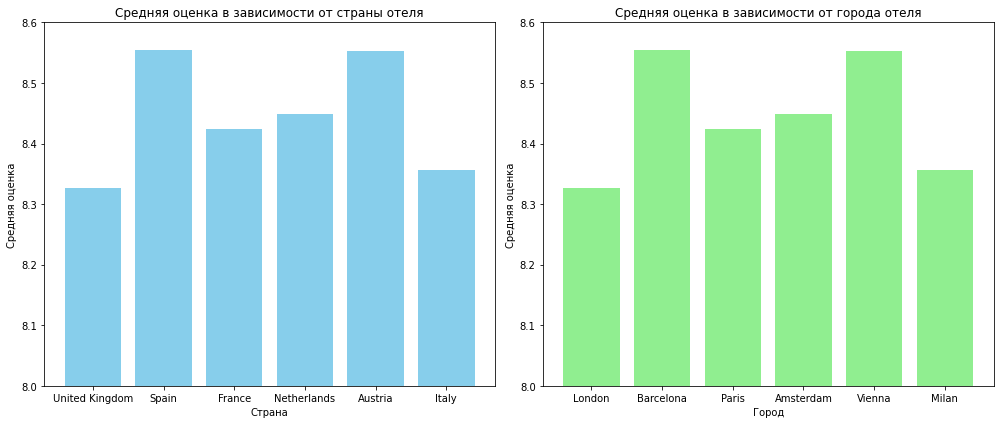

In [81]:
# Построим столбчатые диаграммы для каждой страны и города со средним скором
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].bar(avg_score_by_country['hotel_country'], avg_score_by_country['reviewer_score'], color='skyblue')
axes[0].set_xlabel('Страна')
axes[0].set_ylabel('Средняя оценка')
axes[0].set_title('Средняя оценка в зависимости от страны отеля')
axes[0].set_xticklabels(avg_score_by_country['hotel_country'], rotation=0)
axes[0].set_ylim(8, 8.6)


axes[1].bar(avg_score_by_city['hotel_city'], avg_score_by_city['reviewer_score'], color='lightgreen')
axes[1].set_xlabel('Город')
axes[1].set_ylabel('Средняя оценка')
axes[1].set_title('Средняя оценка в зависимости от города отеля')
axes[1].set_xticklabels(avg_score_by_city['hotel_city'], rotation=0)
axes[1].set_ylim(8, 8.6)

plt.tight_layout()
plt.show()

# Отбор признаков №1

In [82]:
# Посмотрим на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

<AxesSubplot:>

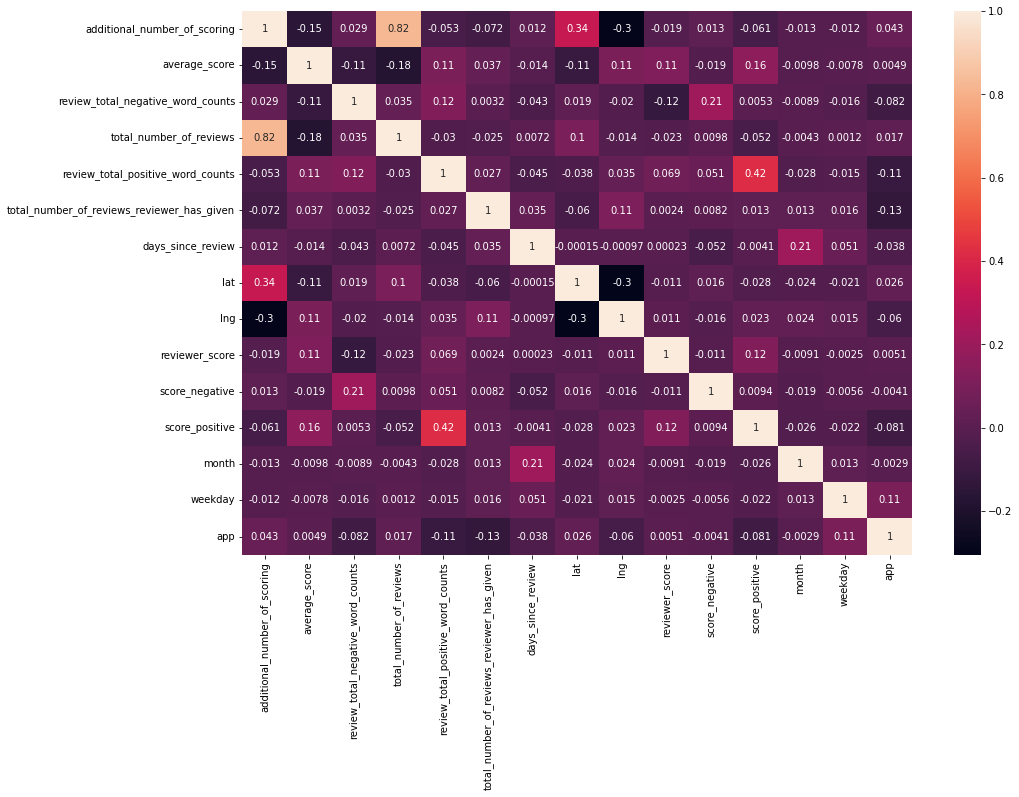

In [83]:
# Посмотрим на корреляцию Пирсона 
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [84]:
# Дропнем адрес отеля (так как мы его расписали на город и страну)
# город отеля (так как данные повторяются)
# лишние лейблы и теги, сезонность отзывов (остановимся на дне недели и месяце)
# координаты, имя отеля, текст отзывов (так как преобразован в целочисленные данные)
data_dropped = data.drop(['hotel_address', 'hotel_city', 'app_label', 'tags', 'tags_new', 'season', 'review_date', 'lat', 'lng', 'negative_review', 'hotel_name', 'positive_review'], axis=1)

# Преобразование признаков и заполнение NaN

In [85]:
# Отберем 5 топ комнат
popular_type_room = data_dropped['room'].value_counts(normalize=True).nlargest(5).index
data_dropped['room'] = data_dropped['room'].apply(lambda x: x if x in popular_type_room else 'other')
data_dropped['room'].describe()

count     515431
unique         6
top        other
freq      369796
Name: room, dtype: object

In [86]:
# Сделаем ohe для комнаты и дропнем ненужный столбец
room_dummies = pd.get_dummies(data_dropped['room'], prefix='room')
data_dropped = pd.concat([data_dropped, room_dummies], axis=1)
data_dropped.drop('room', axis=1, inplace=True)

In [87]:
# Сделаем ohe для цели визита и дропнем ненужный столбец
trip_purpose_dummies = pd.get_dummies(data_dropped['trip_purpose'], prefix='purpose')
data_dropped = pd.concat([data_dropped, trip_purpose_dummies], axis=1)
data_dropped.drop('trip_purpose', axis=1, inplace=True)

In [88]:
# Сделаем ohe для страны отеля и дропнем ненужный столбец
hotel_country_dummies = pd.get_dummies(data_dropped['hotel_country'], prefix='hotel_country')
data_dropped = pd.concat([data_dropped, hotel_country_dummies], axis=1)
data_dropped.drop('hotel_country', axis=1, inplace=True)

In [89]:
# Отберем 5 наиболее популярных национальностей, остальные назовем other, уберем лишние пробелы
popular_nationality = data_dropped['reviewer_nationality'].value_counts(normalize=True).nlargest(5).index
data_dropped['reviewer_nationality'] = data_dropped['reviewer_nationality'].apply(lambda x: x if x in popular_nationality else 'other')
data_dropped['reviewer_nationality'] = data_dropped['reviewer_nationality'].str.strip()

In [90]:
# Сделаем ohe для национальности ревьюрева и дропнем ненужный столбец
reviewer_nationality_dummies = pd.get_dummies(data_dropped['reviewer_nationality'], prefix='reviewer_nationality')
data_dropped = pd.concat([data_dropped, reviewer_nationality_dummies], axis=1)
data_dropped.drop('reviewer_nationality', axis=1, inplace=True)

In [91]:
# Сделаем ohe для статуса постояльца и дропнем ненужный столбец
status_dummies = pd.get_dummies(data_dropped['status'], prefix='status')
data_dropped = pd.concat([data_dropped, status_dummies], axis=1)
data_dropped.drop('status', axis=1, inplace=True)

In [92]:
# Посчитаем медиану для дней размещения 
median_days_of_stay = data_dropped['days_of_stay'].median()
# Заполним NaN медианой
data_dropped['days_of_stay'] = data_dropped['days_of_stay'].fillna(median_days_of_stay)
# Переведем в int
data_dropped['days_of_stay'] = data_dropped['days_of_stay'].astype(int)

# Отбор признаков №2

In [93]:
# Посмотрим на данные
data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 43 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   additional_number_of_scoring                   515431 non-null  int64  
 1   average_score                                  515431 non-null  float64
 2   review_total_negative_word_counts              515431 non-null  int64  
 3   total_number_of_reviews                        515431 non-null  int64  
 4   review_total_positive_word_counts              515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given     515431 non-null  int64  
 6   days_since_review                              515431 non-null  int64  
 7   sample                                         515431 non-null  int64  
 8   reviewer_score                                 515431 non-null  float64
 9   score_negative                       

<AxesSubplot:>

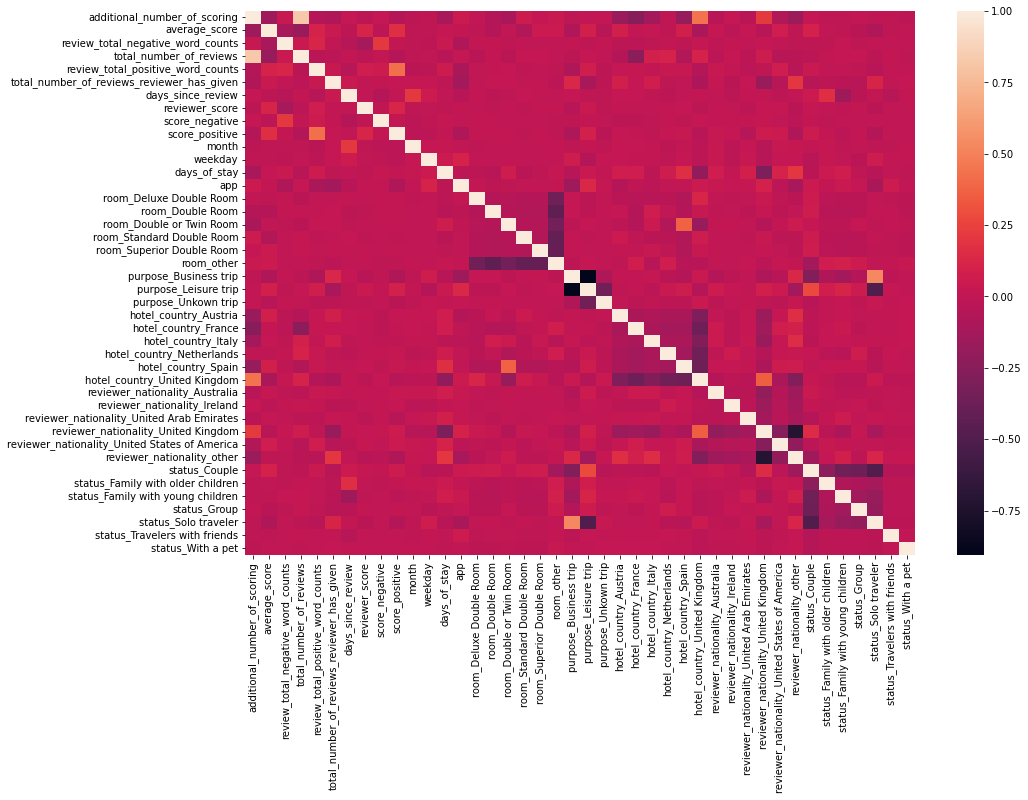

In [94]:
# Посмотрим корреляцию
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_dropped.drop(['sample'], axis=1).corr())

In [95]:
# Дропнем сильно скоррелированные данные
data_dropped = data_dropped.drop(['additional_number_of_scoring', 'room_other', 'purpose_Business trip', 'reviewer_nationality_other', 'status_Solo traveler'], axis=1)

In [96]:
# Посмотрим на данные
data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 38 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   average_score                                  515431 non-null  float64
 1   review_total_negative_word_counts              515431 non-null  int64  
 2   total_number_of_reviews                        515431 non-null  int64  
 3   review_total_positive_word_counts              515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given     515431 non-null  int64  
 5   days_since_review                              515431 non-null  int64  
 6   sample                                         515431 non-null  int64  
 7   reviewer_score                                 515431 non-null  float64
 8   score_negative                                 515431 non-null  float64
 9   score_positive                       

In [97]:
for column in data_dropped.columns:
    # Если тип данных столбца - uint8, преобразуем его в bool
    if data_dropped[column].dtype == 'uint8':
        data_dropped[column] = data_dropped[column].astype(bool)

In [98]:
# Посмотрим на данные
data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 38 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   average_score                                  515431 non-null  float64
 1   review_total_negative_word_counts              515431 non-null  int64  
 2   total_number_of_reviews                        515431 non-null  int64  
 3   review_total_positive_word_counts              515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given     515431 non-null  int64  
 5   days_since_review                              515431 non-null  int64  
 6   sample                                         515431 non-null  int64  
 7   reviewer_score                                 515431 non-null  float64
 8   score_negative                                 515431 non-null  float64
 9   score_positive                       

In [99]:
data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 38 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   average_score                                  515431 non-null  float64
 1   review_total_negative_word_counts              515431 non-null  int64  
 2   total_number_of_reviews                        515431 non-null  int64  
 3   review_total_positive_word_counts              515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given     515431 non-null  int64  
 5   days_since_review                              515431 non-null  int64  
 6   sample                                         515431 non-null  int64  
 7   reviewer_score                                 515431 non-null  float64
 8   score_negative                                 515431 non-null  float64
 9   score_positive                       

In [100]:
numerical_variables = [
    'average_score','review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review', 'score_negative', 'score_positive',
    'days_of_stay'
]
categorical_variables = [
    'month',
    'weekday',
    'app',
    'room_Deluxe Double Room',
    'room_Double Room',
    'room_Double or Twin Room',
    'room_Standard Double Room',
    'room_Superior Double Room',
    'purpose_Leisure trip',
    'purpose_Unkown trip',
    'hotel_country_Austria',
    'hotel_country_France',
    'hotel_country_Italy',
    'hotel_country_Netherlands',
    'hotel_country_Spain',
    'hotel_country_United Kingdom',
    'reviewer_nationality_Australia',
    'reviewer_nationality_Ireland',
    'reviewer_nationality_United Arab Emirates',
    'reviewer_nationality_United Kingdom',
    'reviewer_nationality_United States of America',
    'status_Couple',
    'status_Family with older children',
    'status_Family with young children',
    'status_Group',
    'status_Travelers with friends',
    'status_With a pet'
]

<AxesSubplot:>

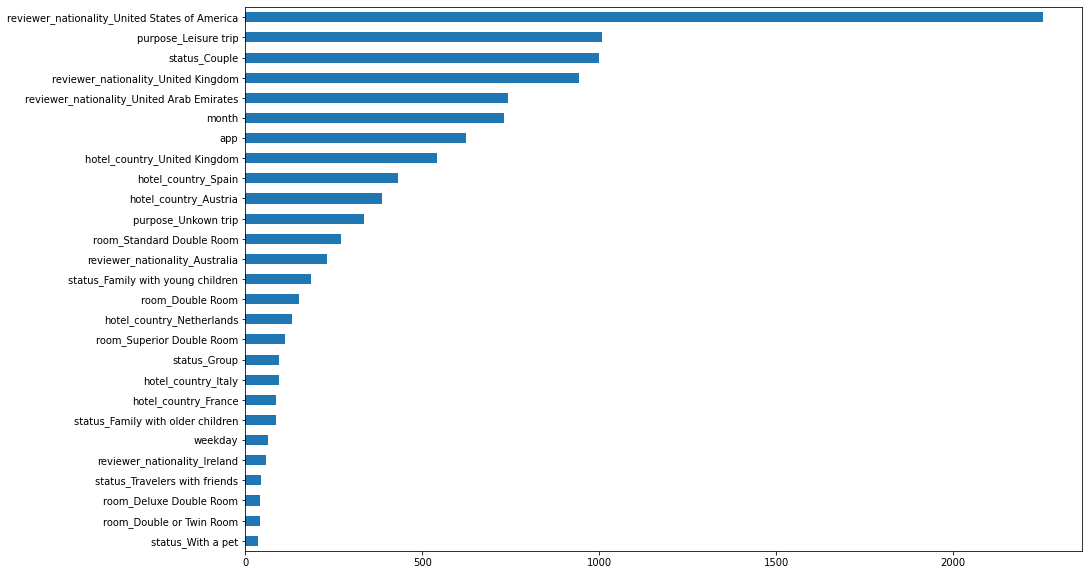

In [101]:
# Импорт библиотеки
from sklearn.feature_selection import chi2

# Использование непараметрического теста хи-квадрат (Chi-squared test) в контексте выбора признаков для машинного обучения позволяет оценить статистическую значимость взаимосвязи между каждой категориальной переменной (признаком) и целевой переменной
y = data_dropped.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data_dropped.query('sample == 1').drop(['sample'], axis=1)[categorical_variables]

# Выведем значения хи-квадрат на графике:
imp_cat = pd.Series(chi2(X, y)[0], index=categorical_variables)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [102]:
imp_cat

status_With a pet                                  34.352807
room_Double or Twin Room                           39.880781
room_Deluxe Double Room                            41.858907
status_Travelers with friends                      43.006544
reviewer_nationality_Ireland                       56.925737
weekday                                            64.240050
status_Family with older children                  86.339136
hotel_country_France                               87.561657
hotel_country_Italy                                95.046373
status_Group                                       95.885180
room_Superior Double Room                         110.396770
hotel_country_Netherlands                         130.218251
room_Double Room                                  152.287104
status_Family with young children                 185.482741
reviewer_nationality_Australia                    229.528422
room_Standard Double Room                         270.794335
purpose_Unkown trip     

In [103]:
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer

# Для оценки значимости непрерывных переменных используем ANOVA из библиотеки sklearn
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')  # Извлекаем целевую переменную
X = data.query('sample == 1').drop(['sample'], axis=1)[numerical_variables]  # Извлекаем непрерывные переменные

# Объект для заполнения NaN
imputer = SimpleImputer(strategy='median')

# Трасформируем данные
X_imputed = imputer.fit_transform(X)

# Конвертируем в датафрейм
X_imputed_df = pd.DataFrame(X_imputed, columns=numerical_variables)

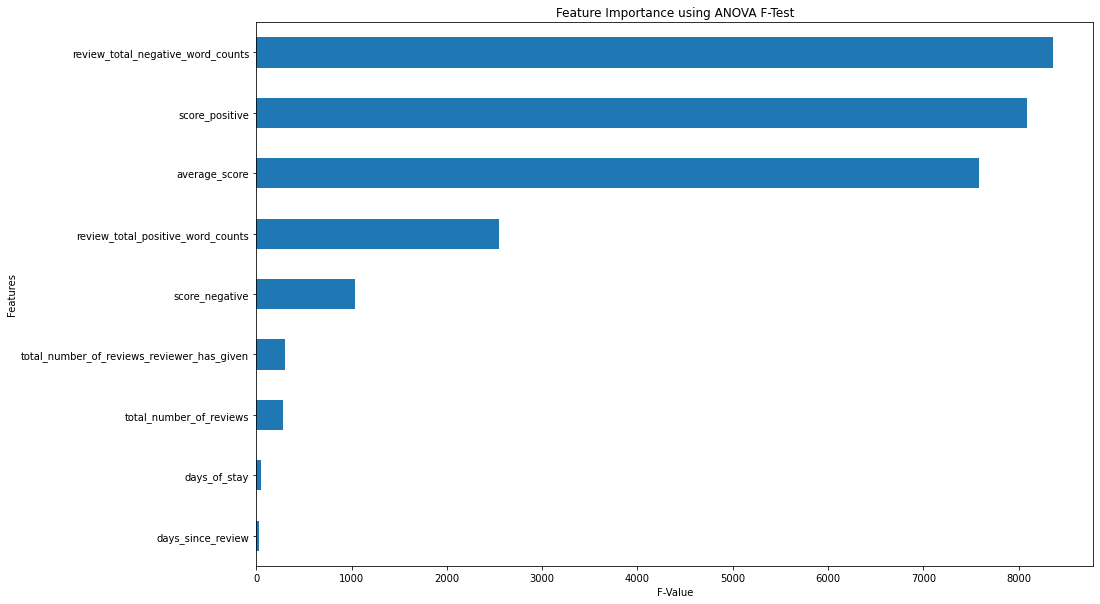

In [104]:
# Применим f_classif
f_values, p_values = f_classif(X_imputed_df, y)

# Выведем f_values на графике
imp_num = pd.Series(f_values, index=numerical_variables)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Feature Importance using ANOVA F-Test')
plt.xlabel('F-Value')
plt.ylabel('Features')
plt.show()

In [105]:
imp_num

days_since_review                               26.722059
days_of_stay                                    47.599910
total_number_of_reviews                        277.930171
total_number_of_reviews_reviewer_has_given     299.803806
score_negative                                1040.148073
review_total_positive_word_counts             2550.332232
average_score                                 7588.683414
score_positive                                8089.710480
review_total_negative_word_counts             8366.065720
dtype: float64

In [106]:
data_dropped_copy = data_dropped.copy()
data_dropped = data_dropped.drop(['days_since_review','days_of_stay', 'days_since_review', 'status_With a pet', 'room_Double or Twin Room', 'room_Deluxe Double Room', 'status_Travelers with friends'], axis=1)

# Обучение модели

In [107]:
# Теперь выделим тестовую часть
train_data = data_dropped.query('sample == 1').drop(['sample'], axis=1)
test_data = data_dropped.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [108]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [109]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 31), (386496, 31), (386496, 30), (309196, 30), (77300, 30))

In [110]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [111]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [112]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [113]:
def mape_func(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [114]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
print('MAPE:', mape_func(y_test, y_pred))

MAPE: 12.54359203226495


<AxesSubplot:>

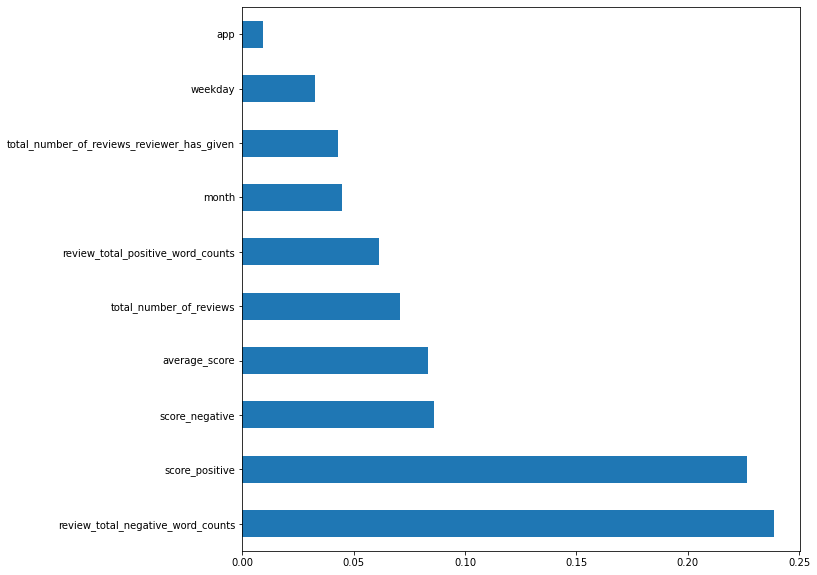

In [115]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [116]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,score_negative,score_positive,month,weekday,...,hotel_country_United Kingdom,reviewer_nationality_Australia,reviewer_nationality_Ireland,reviewer_nationality_United Arab Emirates,reviewer_nationality_United Kingdom,reviewer_nationality_United States of America,status_Couple,status_Family with older children,status_Family with young children,status_Group
91327,8.0,0,3078,6,85,0.0,-0.7096,0.0000,4,3,...,False,False,False,False,True,False,False,False,False,False
4948,8.6,0,1572,8,1,0.0,-0.7096,0.5574,10,0,...,True,False,False,False,True,False,True,False,False,False
58330,9.3,0,2011,4,4,0.0,-0.7096,0.6115,4,3,...,False,False,True,False,False,False,True,False,False,False
83346,8.9,13,857,3,2,0.0,-0.6908,-0.2960,5,4,...,True,False,False,False,False,False,True,False,False,False
70179,8.3,56,1640,31,2,0.0,-0.5943,0.8439,5,3,...,True,False,False,False,True,False,False,False,True,False
112531,7.8,10,5945,8,6,0.0,0.0000,0.4927,2,1,...,True,False,False,False,False,False,True,False,False,False
60265,8.5,0,3269,16,6,0.0,-0.7096,0.8908,11,3,...,True,False,False,False,False,False,False,False,True,False
25199,8.4,0,1708,9,1,0.0,-0.7096,0.8910,8,1,...,True,False,False,False,True,False,True,False,False,False
9074,9.0,13,1258,7,2,0.0,0.0000,0.0000,8,3,...,False,False,False,False,False,False,False,False,True,False
67403,8.0,0,435,19,4,0.0,-0.7096,0.3071,4,1,...,False,False,False,False,True,False,False,False,False,False


In [117]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [118]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [119]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished


In [120]:
predict_submission

array([8.634, 7.69 , 8.811, ..., 8.195, 9.578, 6.847])

In [121]:
list(sample_submission)

['reviewer_score', 'id']

In [122]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.634,488440
1,7.690,274649
2,8.811,374688
3,9.635,404352
4,9.438,451596
5,9.035,302161
6,7.856,317079
7,7.366,13963
8,8.616,159785
9,7.927,195089
